# Wavelet Analysis

Evaluation of the impact of several aspect for the choosen method for dimension reduction. The tuned parameters for DWT are:
* Wavelet Function
* Frequency Resolution
* Time Resolution

**Load Data**

In [1]:
import sys
sys.path.append('..')
from utils import *

/home/nvlaminc/Documents/Projects/Ariac/building/TRAIL_workshops/venv_workshop2022/lib64/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
file_path = '../../QuickStart/Data/Electricity/residential_all_hour_with_date_time.pkl'
x_date_time = pd.read_pickle(file_path)

**Smooth Data**

In [26]:
x_date_time = gaussian_smoothing(x_date_time)

**Keep 1st Year**

In [4]:
# Take just the first 365 days
df_sorted = x_date_time.sort_values(by='date_time')
df = df_sorted["2009-07-15" : "2010-07-14"]
x = np.array(df).T

**Removing Outlier**

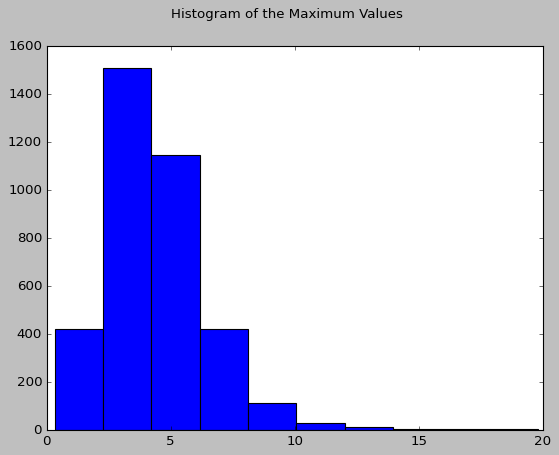

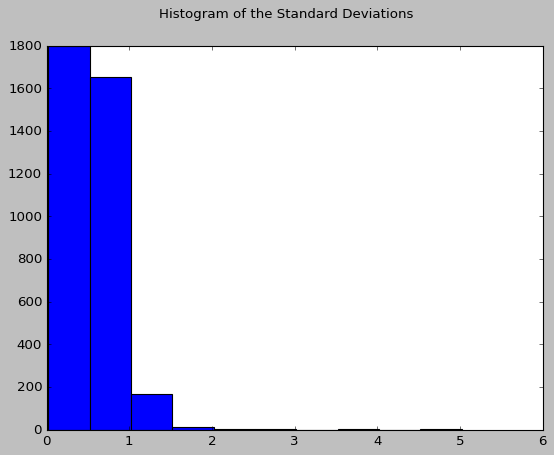

In [12]:
#Inspection of the histograms of the variance and maximum of hourly kWh
fig = plt.figure()
_ = plt.hist(x.max(1))
plt.suptitle('Histogram of the Maximum Values')
plt.show()

fig = plt.figure()
_ = plt.hist(x.std(1))
plt.suptitle('Histogram of the Standard Deviations')
plt.show()

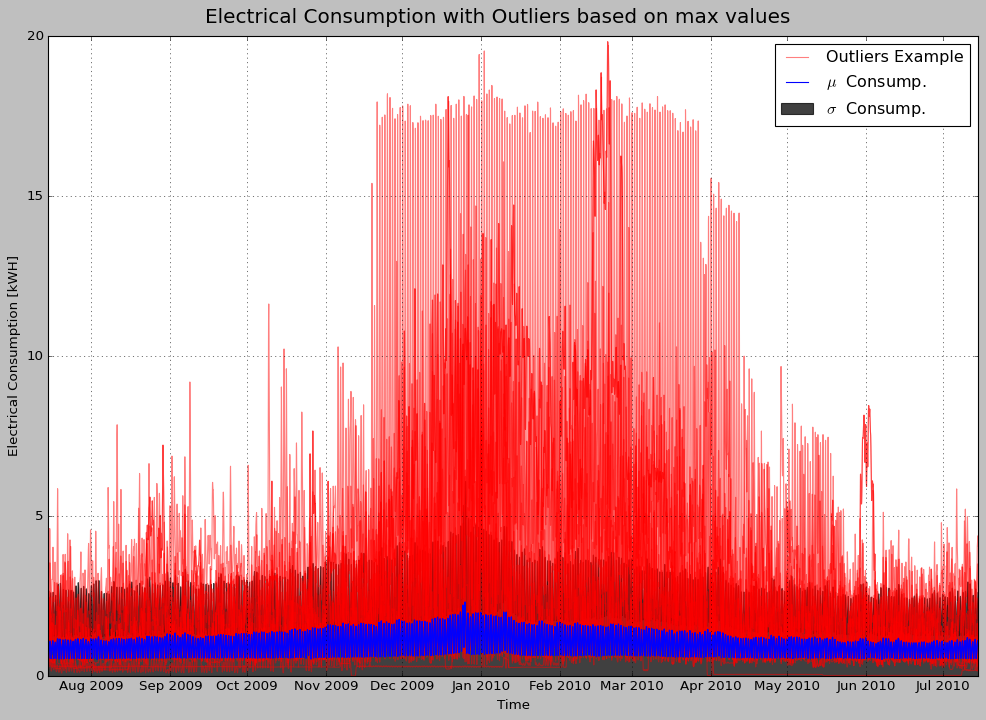

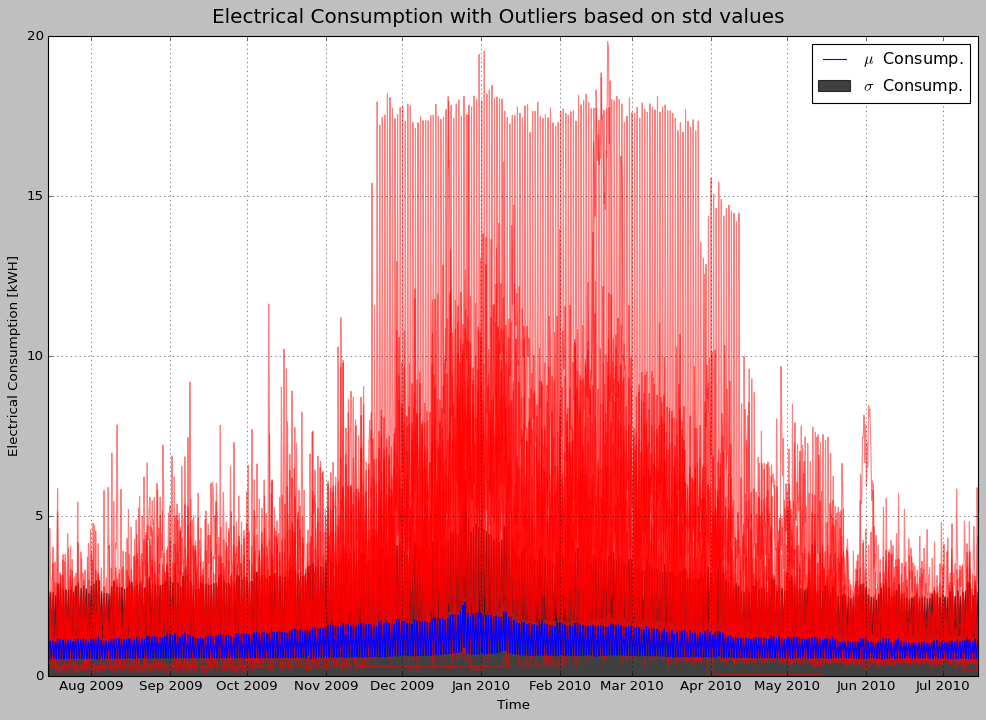

In [5]:
id_remove = []
t = pd.date_range(start="2009-07-15" , end="2010-07-14 23:00:00", freq="60T", name='date_time')

#Remove consumers corresponding to the 10 max values
plt.figure(figsize=(15, 10))
for i in np.argsort(-x.max(1))[:10]:
    id_remove.append(i)
    plt.plot(t, x[i], alpha=0.5, color='red')
plt.plot(t, x[1152], alpha=0.5, color='red', label='Outliers Example')
plt.plot(t, x.mean(0), label=r'$\mu$  Consump.')
plt.fill_between(t, x.mean(0)-2*x.std(0), x.mean(0)+2*x.std(0), 
                 color='black', alpha=0.75, label=r'$\sigma$  Consump.')
plt.plot(t, x.mean(0), color='blue')
plt.legend()
ax = plt.gca()
ax.set_ylim([0, 20])
plt.grid()
plt.suptitle('Electrical Consumption with Outliers based on max values', size=18, y=0.935)
plt.xlabel('Time')
plt.ylabel('Electrical Consumption [kWH]')
#plt.savefig('Outliers_all_year.png', dpi=600)

#Remove consumers corresponding to the 10 bigger std values
plt.figure(figsize=(15, 10))
for i in np.argsort(-x.std(1))[:10]:
    id_remove.append(i)
    plt.plot(t, x[i], alpha=0.5, color='red')
plt.fill_between(t, x.mean(0)-2*x.std(0), x.mean(0)+2*x.std(0), 
                 color='black', alpha=0.75, label=r'$\sigma$  Consump.')
plt.plot(t, x.mean(0), color='blue', label=r'$\mu$  Consump.')
plt.legend()
ax = plt.gca()
ax.set_ylim([0, 20])
plt.grid()
plt.suptitle('Electrical Consumption with Outliers based on std values', size=18, y=0.935)
plt.xlabel('Time')
plt.ylabel('Electrical Consumption [kWH]')

id_remove = np.asarray(id_remove)

In [6]:
#Remove outliers with Isolation Forest
outliers_fraction = 0.01
clf = IsolationForest(random_state=0, contamination = outliers_fraction, n_jobs=-1).fit(x)
pred = clf.predict(x)

In [7]:
#Concatenate all the outliers IDs
id_remove = np.concatenate((id_remove, np.squeeze(np.argwhere((pred==-1)))))
id_remove = np.unique(id_remove)

(3595, 8760)


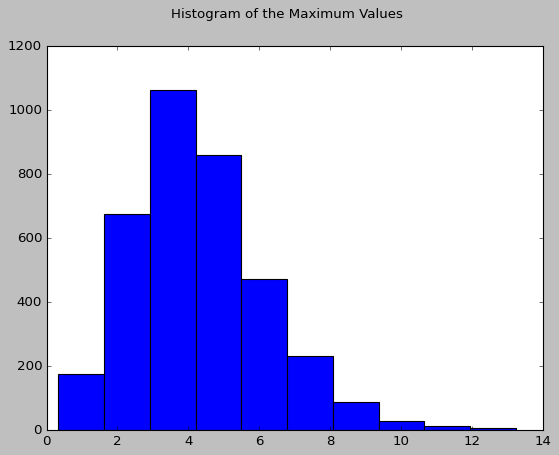

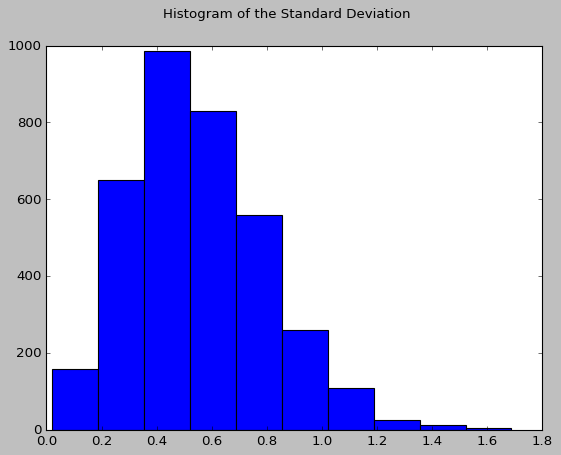

In [8]:
#Check max and std values in hourly kWh after outlier removal
x_ = np.delete(x, id_remove, 0)
print(x_.shape)
    
fig = plt.figure()
_ = plt.hist(x_.max(1))
plt.suptitle('Histogram of the Maximum Values')
plt.show()

fig = plt.figure()
_ = plt.hist(x_.std(1))
plt.suptitle('Histogram of the Standard Deviation')
plt.show()

x = x_

## Baselines

In [11]:
#Evaluate KMeans baseline
kmeans = KMeans(n_clusters=4, random_state=0).fit(x)
ch_x_base = calinski_harabasz_score(x, kmeans.predict(x))
sc_x_base = silhouette_score(x, kmeans.predict(x))
print(ch_x_base)
print(sc_x_base)

960.9048296941102
0.11903929678602573


In [12]:
#Evaluate Kmeans + PCA baseline
x_pca = PCA(n_components=10).fit_transform(x)
kmeans = KMeans(n_clusters=4, random_state=0).fit(x_pca)
ch_x_pca = calinski_harabasz_score(x, kmeans.predict(x_pca))
sc_x_pca = silhouette_score(x, kmeans.predict(x_pca))
print(ch_x_pca)
print(sc_x_pca)

960.90482969411
0.11903929678602573


## Autocorrelation

Tested Kmeans and Spectral Clustering on the autocorrelation matrix instead of PCA to see if we can get some good CH and Silhouette scores at less computational cost. Conclusion: worse CH, slightly better Silhouette.



In [26]:
def vec_autocorr(z):
    z_ = np.array(z) 
    # Mean
    mean_val = np.mean(z_)
    # Variance
    var_val = np.var(z_)
    # Normalized data
    ndata = z_ - mean_val
    acorr = np.correlate(ndata, ndata, 'full')[len(ndata)-1:] 
    acorr = acorr / var_val / len(ndata)
    return acorr

acorr_arr = np.apply_along_axis(vec_autocorr, 1, x)

In [27]:
from sklearn.preprocessing import StandardScaler

lag = 24*28
n_cluster = 10
period = 'D'
acorr_sub = acorr_arr[:,1:(lag + 1)]
# sc = StandardScaler()
# acorr_norm = sc.fit_transform(acorr_sub)
acorr_norm = acorr_sub

In [28]:
#Evaluate KMeans + autocorrelations
for k_val in np.arange(2, 11):
    kmeans = KMeans(n_clusters=k_val, random_state=0).fit(acorr_norm)
    CH = calinski_harabasz_score(x, kmeans.predict(acorr_norm))
    sil = silhouette_score(x, kmeans.predict(acorr_norm))
    print(k_val, CH, sil)

2 154.31793365616528 0.04280345027957668
3 101.22806236329438 0.02468104320327389
4 87.20283394860888 -0.025097818163629514
5 72.57210068211714 -0.03579675729682167
6 58.56666148067606 -0.04808316097299559
7 49.97891756101804 -0.05949305546164063
8 42.88601196944017 -0.072602943971242
9 40.81841503127655 -0.0747903558602561
10 36.29669917268737 -0.07618319675652352


In [30]:
#Evaluate Spectral clustering + autocorrelations
from sklearn.cluster import SpectralClustering
for k_val in np.arange(2, 20):
    spec_clust = SpectralClustering(n_clusters=k_val, random_state=0, affinity = "nearest_neighbors").fit(acorr_norm)
    CH = calinski_harabasz_score(x, spec_clust.labels_)
    sil = silhouette_score(x, spec_clust.labels_)
    print(k_val, CH, sil)

2 132.0441289275431 0.033540388251052475
3 61.35357631966938 0.017556899834688867
4 75.60196470673218 -0.01038622231859109
5 62.08972465948459 -0.015716426074755464
6 54.86824093021893 -0.03455771922825535
7 47.12972635098966 -0.04285342400302199
8 40.248296529023214 -0.045185064994102866
9 39.632588208907045 -0.07130229936857474
10 37.44239071426181 -0.07651234700822315
11 34.522068772605714 -0.07992757522800771
12 30.99672938749744 -0.08195814404325008
13 29.92050482403047 -0.08213945870951793
14 28.16049007064389 -0.08592075555299054
15 25.809872803876146 -0.09475328723010151
16 24.149661067973458 -0.09392333354111627
17 23.27582200695768 -0.09369773383584064
18 22.626575532445198 -0.09536910310079803
19 22.451848418981424 -0.1159178225573055


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering

lag = 24*28
n_cluster = 10
period = 'D'
acorr_sub = acorr_arr[:,1:(lag + 1)]
# sc = StandardScaler()
# acorr_norm = sc.fit_transform(acorr_sub)
acorr_norm = acorr_sub

for k_val in np.arange(2, 20):
    spec_clust = SpectralClustering(n_clusters=k_val, random_state=0, affinity = "nearest_neighbors").fit(acorr_norm)
    CH = calinski_harabasz_score(x, spec_clust.labels_)
    sil = silhouette_score(x, spec_clust.labels_)
    print(k_val, CH, sil)


## Wavelet Function

Choosen wavelet function, coif5, sym10 and db8.

In [13]:
import pywt

def multi_level_dwt(x, wav_func='coif5', level=None):
    c = pywt.wavedec(x, wavelet=wav_func, level=level)
    return c[0]

def evaluate_wavelet_function(x, wav_func='coif5', n_cluster=4, period='D'):
    level = []
    scores = []
    for l in tqdm(np.arange(pywt.dwt_max_level(data_len=x.shape[1], filter_len=pywt.Wavelet(wav_func).dec_len))):
        x_dwt = multi_level_dwt(x, wav_func=wav_func, level=l)
        kmeans = KMeans(n_clusters=n_cluster, random_state=0).fit(x_dwt)
        # Calculate CH and sil for all time points at once (high-dimensional)
        CH = calinski_harabasz_score(x, kmeans.predict(x_dwt))
        sil = silhouette_score(x, kmeans.predict(x_dwt))
        scores.append([CH, sil])
        level.append(l)
    return np.array(scores), np.array(level)

In [14]:
metrics_alone = {}
wave_func = ['coif5', 'sym10', 'db8']
for k in wave_func:
    s, l = evaluate_wavelet_function(x, wav_func=k)
    metrics_alone[k] = s

100%|██████████| 9/9 [01:07<00:00,  7.52s/it]


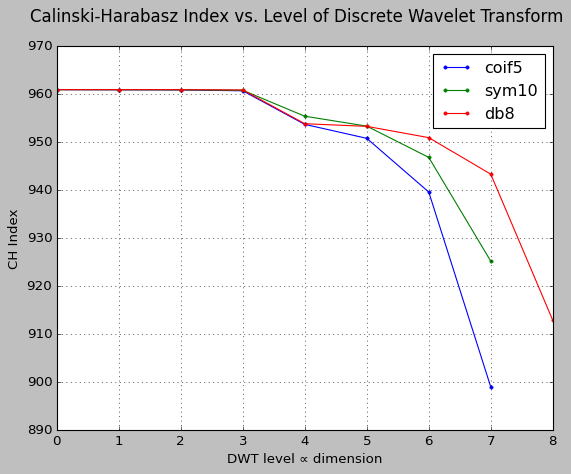

In [15]:
fig = plt.figure()
plt.style.use('classic')

for k in metrics_alone.keys():
    plt.plot(np.array(metrics_alone[k])[:, 0], '.-', label=k)

plt.grid()
plt.suptitle('Calinski-Harabasz Index vs. Level of Discrete Wavelet Transform', size=15)
plt.ylabel('CH Index')
plt.xlabel('DWT level ∝ dimension')
plt.legend()

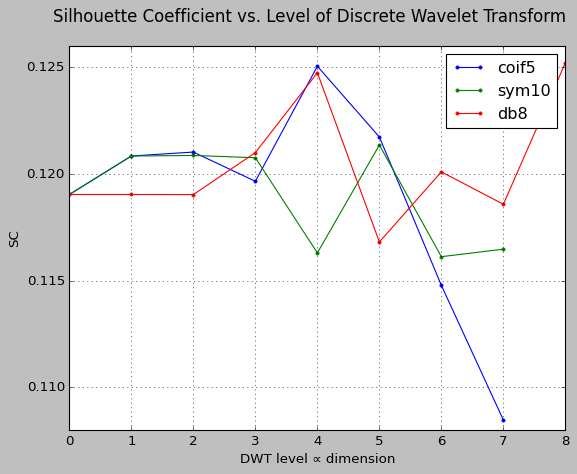

In [17]:
fig = plt.figure()
plt.style.use('classic')

for k in metrics_alone.keys():
    plt.plot(np.array(metrics_alone[k])[:, 1], '.-', label=k)

plt.grid()
plt.suptitle('Silhouette Coefficient vs. Level of Discrete Wavelet Transform', size=15)
plt.ylabel('SC')
plt.xlabel('DWT level ∝ dimension')
plt.legend()

#We can see that the Silhouette coefficient is not stable, it may be due to clusters overlapping

See if normalization matters by testing with normalization for one wavelet + hp combo.
It seems like results are similar.

In [27]:
#Do not work anymore with the outlier removal
from sklearn.preprocessing import StandardScaler

n_cluster = 4
l = 1
period='D'
wav_func='db8'
df_sorted = x_date_time.sort_values(by='date_time')
df = df_sorted["2009-07-15" : "2010-07-14"]
x_date_time = np.array(df).T
x_dwt = multi_level_dwt(x_date_time, wav_func=wav_func, level=l)
sc = StandardScaler()
x_dwt_norm = sc.fit_transform(x_dwt)
kmeans = KMeans(n_clusters=n_cluster, random_state=0).fit(x_dwt_norm)
CH = df.groupby(df.index.to_period(period)).apply(lambda z: calinski_harabasz_score(np.array(z).T, kmeans.predict(x_dwt_norm))).mean()
sil = df.groupby(df.index.to_period(period)).apply(lambda z: silhouette_score(np.array(z).T, kmeans.predict(x_dwt_norm))).mean()
print(n_cluster, CH, sil)

4 964.124299056155 0.12094895343479936


## Combination with PCA

In [34]:
import pywt
from sklearn.decomposition import PCA

def multi_level_dwt(x, wav_func='coif5', level=None):
    c = pywt.wavedec(x, wavelet=wav_func, level=level)
    return c[0]

def evaluate_wavelet_function(x, wav_func='coif5', n_cluster=4):
    level = []
    scores = []
    for l in np.arange(pywt.dwt_max_level(data_len=x.shape[1], filter_len=pywt.Wavelet(wav_func).dec_len)):
        x_dwt = multi_level_dwt(x, wav_func=wav_func, level=l)
        kmeans = KMeans(n_clusters=n_cluster, random_state=0).fit(x_dwt)
        scores.append([calinski_harabasz_score(x, kmeans.predict(x_dwt)), silhouette_score(x, kmeans.predict(x_dwt))])
        level.append(l)
    return np.array(scores), np.array(level)

def ver_wavfunc(x, wav_func='coif5'):
    fig = plt.figure()
    for l in tqdm(np.arange(pywt.dwt_max_level(data_len=x.shape[1], filter_len=pywt.Wavelet(wav_func).dec_len))):
        x_dwt = multi_level_dwt(x, wav_func=wav_func, level=l)
        pca = PCA(n_components=np.min([1000, x_dwt.shape[-1]]))
        pca.fit(x_dwt)
        plt.plot(1 - pca.explained_variance_ratio_[:15], label=f'{wav_func} - level {l+1}')
    ax = plt.gca()
    ax.set_ylim([0.875, 1.005])
    plt.grid()
    plt.ylabel('Exlpained Variance Ratio')
    plt.xlabel('# of Components')
    plt.suptitle(f'Variance Explained Ratio for Level for {wav_func} function')
    plt.legend()
    plt.show()
    
def evaluate_pca_wavelet(x, wav_func='coif5', n_cluster=4, n_components=10):
    level = []
    scores = []
    for l in tqdm(np.arange(pywt.dwt_max_level(data_len=x.shape[1], filter_len=pywt.Wavelet(wav_func).dec_len))):
        x_dwt = multi_level_dwt(x, wav_func=wav_func, level=l)
        x_dwt = PCA(n_components=n_components).fit_transform(x_dwt)
        kmeans = KMeans(n_clusters=n_cluster, random_state=0).fit(x_dwt)
        scores.append([calinski_harabasz_score(x, kmeans.predict(x_dwt)), silhouette_score(x, kmeans.predict(x_dwt))])
        level.append(l)
    return np.array(scores), np.array(level)

### Explained PCA Variance Ratio Analysis

100%|██████████| 8/8 [00:53<00:00,  6.70s/it]


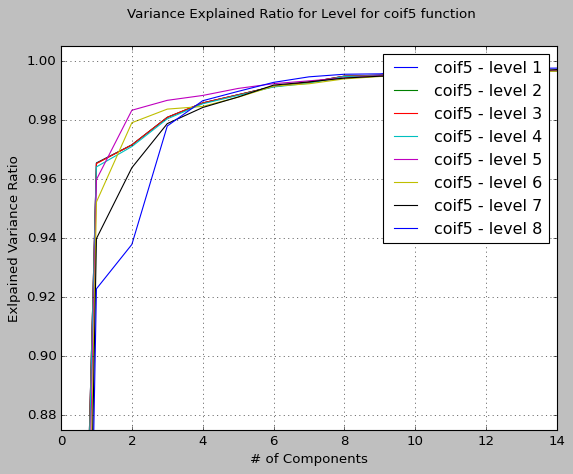

In [30]:
ver_wavfunc(x, 'coif5')

100%|██████████| 8/8 [00:46<00:00,  5.83s/it]


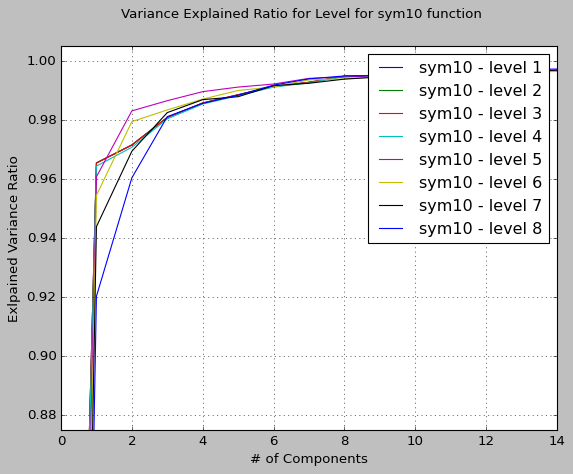

In [35]:
ver_wavfunc(x, 'sym10')

100%|██████████| 9/9 [00:42<00:00,  4.76s/it]


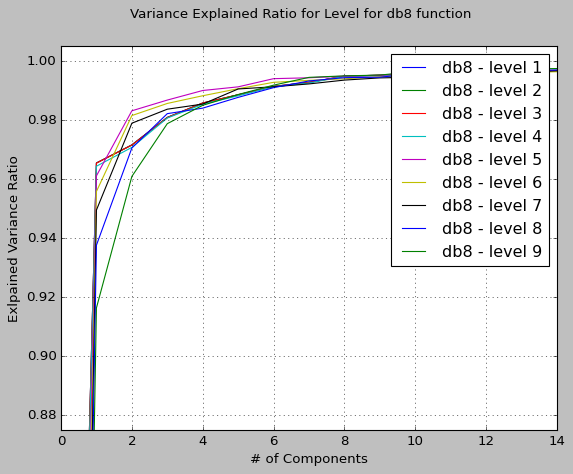

In [36]:
ver_wavfunc(x, 'db8')

So enough with 10 components for each methodology.

### Clustering on combined methods

In [37]:
metrics_pca = {}
wave_func = ['coif5', 'sym10', 'db8']
for k in wave_func:
    s, l = evaluate_pca_wavelet(x, wav_func=k)
    metrics_pca[k] = s

100%|██████████| 9/9 [00:44<00:00,  4.92s/it]


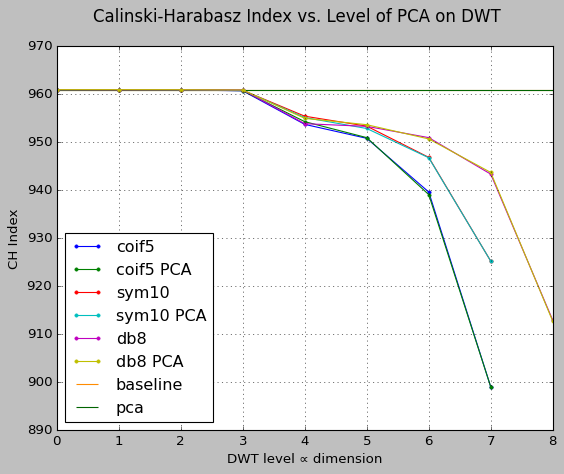

In [38]:
fig = plt.figure()
plt.style.use('classic')

for k in metrics_alone.keys():
    plt.plot(np.array(metrics_alone[k])[:, 0], '.-', label=k)
    plt.plot(np.array(metrics_pca[k])[:, 0], '.-', label=k+' PCA')

'''
ax = plt.gca()
ax.set_ylim([122, 127])
'''
plt.hlines(ch_x_base, 0, 8, color='darkorange', label='baseline')
plt.hlines(ch_x_pca, 0, 8, color='darkgreen', label='pca')
plt.grid()
plt.suptitle('Calinski-Harabasz Index vs. Level of PCA on DWT', size=15)
plt.ylabel('CH Index')
plt.xlabel('DWT level ∝ dimension')
plt.legend(loc=3)
plt.savefig('ch_dwt.svg', dpi = 600)

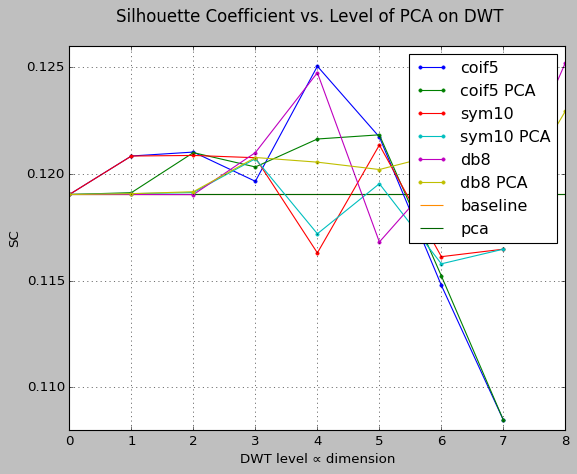

In [40]:
fig = plt.figure()
plt.style.use('classic')

for k in metrics_alone.keys():
    plt.plot(np.array(metrics_alone[k])[:, 1], '.-', label=k)
    plt.plot(np.array(metrics_pca[k])[:, 1], '.-', label=k+' PCA')

plt.hlines(sc_x_base, 0, 8, color='darkorange', label='baseline')
plt.hlines(sc_x_pca, 0, 8, color='darkgreen', label='pca')

plt.grid()

plt.suptitle('Silhouette Coefficient vs. Level of PCA on DWT', size=15)
plt.ylabel('SC')
plt.xlabel('DWT level ∝ dimension')
plt.legend(loc=1)
plt.savefig('sc_dwt.svg', dpi = 800)

## Best Representation

Time to cluster the dataset 5.68 s.


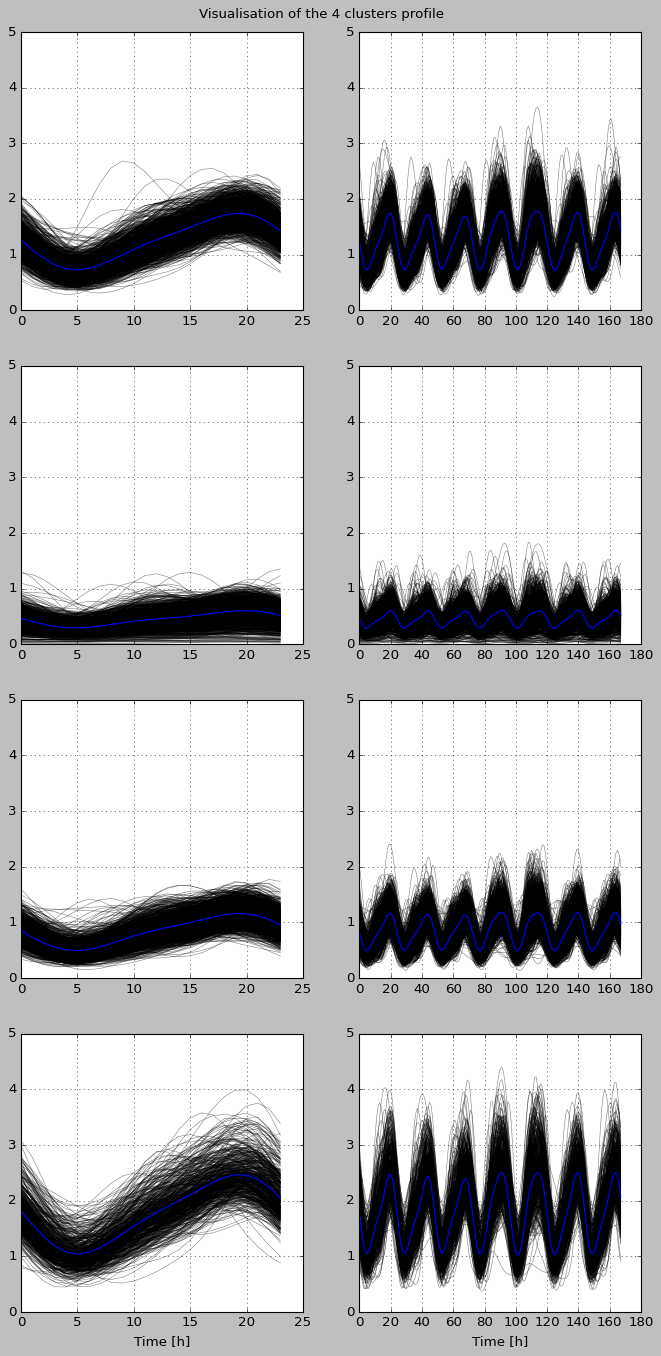

In [41]:
#best_l = 5
#best_wav_func='db8'
# x_dwt = multi_level_dwt(x, wav_func=best_wav_func, level=best_l)

#Only keep PCA finally
n_components = 10
n_cluster = 4
t = time.time()
x_pca = PCA(n_components=n_components).fit_transform(x)
kmeans = KMeans(n_clusters=n_cluster, random_state=0).fit(x_pca)
print(f'Time to cluster the dataset {time.time()-t:.2f} s.')
plot_clusters(x, kmeans.predict(x_pca))

## PCA Analysis Components vs. Clusters

In [42]:
def evaluate_pca_kmean(x, n_cluster, n_components):
    x_pca = PCA(n_components=n_components).fit_transform(x)
    kmeans = KMeans(n_clusters=n_cluster, random_state=0).fit(x_pca)
    CH = calinski_harabasz_score(x, kmeans.predict(x_pca))
    sil = silhouette_score(x, kmeans.predict(x_pca))
    return np.array([CH, sil])

In [43]:
pca_compents = [5, 10, 20] #CH does not vary a lot so can keep 10 components
n_clusters   = np.arange(18)+2
        
ch_2 = np.zeros((len(pca_compents), len(n_clusters)))
si_2 = np.zeros((len(pca_compents), len(n_clusters)))

for c in tqdm(range(len(n_clusters))):
    for p in range(len(pca_compents)):
        ch_2[p, c], si_2[p, c] = evaluate_pca_kmean(x, n_clusters[c], pca_compents[p])

100%|██████████| 18/18 [06:48<00:00, 22.71s/it]


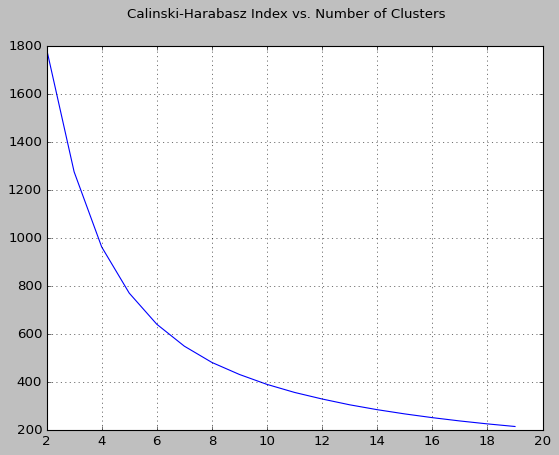

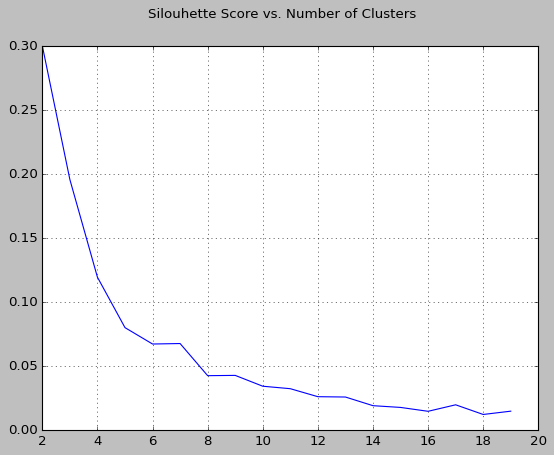

In [44]:
fig = plt.figure()
plt.plot(n_clusters, ch_2[1, :])
plt.grid()
plt.suptitle('Calinski-Harabasz Index vs. Number of Clusters')
plt.show()

fig = plt.figure()
plt.plot(n_clusters, si_2[1, :])
plt.grid()
plt.suptitle('Silouhette Score vs. Number of Clusters')
plt.show()

/home/nvlaminc/Documents/Projects/Ariac/building/TRAIL_workshops/venv_workshop2022/lib64/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/nvlaminc/Documents/Projects/Ariac/building/TRAIL_workshops/venv_workshop2022/lib64/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


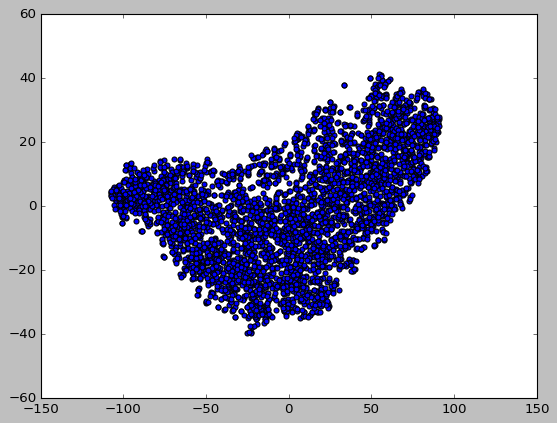

In [47]:
from sklearn.manifold import TSNE

x_pca = PCA(n_components=10).fit_transform(x)
x_tsne = TSNE(n_components=2, n_jobs=-1).fit_transform(x_pca)

fig = plt.figure()
plt.scatter(x_tsne[:, 0], x_tsne[:, 1])
plt.show()

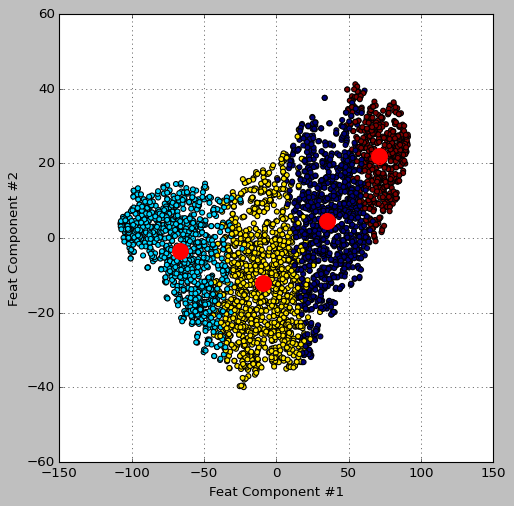

In [49]:
fig = plt.figure(figsize=(7, 7))

plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=kmeans.predict(x_pca))

for i in range(4):
    plt.scatter(x_tsne[kmeans.predict(x_pca)==i].mean(0)[0], x_tsne[kmeans.predict(x_pca)==i].mean(0)[1], s=200, color='red')
plt.grid()
plt.xlabel('Feat Component #1')
plt.ylabel('Feat Component #2')

plt.savefig('feat_clusters.svg', transparent=True, dpi=500, bbox_inches='tight')